In [1]:
import ee 
import folium
from datetime import datetime as dt
from IPython.display import Image
import tensorflow as tf
import matplotlib.pyplot as plt
import os
from google.cloud import storage
import time
import numpy as np
from tensorflow.python.keras import layers
from tensorflow.python.keras import losses
from tensorflow.python.keras import models
from tensorflow.python.keras import metrics
from tensorflow.python.keras import optimizers
from google.colab import auth
from tensorflow.keras.callbacks import EarlyStopping

In [2]:
auth.authenticate_user()

In [3]:
ee.Authenticate()

To authorize access needed by Earth Engine, open the following URL in a web browser and follow the instructions. If the web browser does not start automatically, please manually browse the URL below.

    https://accounts.google.com/o/oauth2/auth?client_id=517222506229-vsmmajv00ul0bs7p89v5m89qs8eb9359.apps.googleusercontent.com&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fearthengine+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdevstorage.full_control&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&response_type=code&code_challenge=fzstGKAJbp6BPolzvwE12PYT4IjlfW6jWPXbw2pY6Rc&code_challenge_method=S256

The authorization workflow will generate a code, which you should paste in the box below. 
Enter verification code: 4/1AY0e-g7kmwY14YdI18gCTmX6PsWhn18XlQYBRXmfMiCD8jgsC5K-ioORaVY

Successfully saved authorization token.


In [2]:
ee.Initialize()

EEException: ignored

## Global variables

In [5]:
BUCKET = 'forest_guard_bucket'  # ⚠️ replace with your BUCKET NAME
FOLDER = 'data_forest_guards'
TRAINING_BASE = 'training_patches'
EVAL_BASE = 'eval_patches'

OPTICAL_BANDS = ['B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7']
THERMAL_BANDS = ['B10', 'B11']
BANDS = OPTICAL_BANDS + THERMAL_BANDS
RESPONSE = 'fnf'
FEATURES = BANDS + [RESPONSE]

# Specify the size and shape of patches expected by the model.
KERNEL_SIZE = 256
KERNEL_SHAPE = [KERNEL_SIZE, KERNEL_SIZE]

COLUMNS = [
  tf.io.FixedLenFeature(shape=KERNEL_SHAPE, dtype=tf.float32) for k in FEATURES
]
FEATURES_DICT = dict(zip(FEATURES, COLUMNS))

# Sizes of the training and evaluation datasets.
TRAIN_SIZE = 16000
EVAL_SIZE = 8000

# Specify model training parameters.
BATCH_SIZE = 16
EPOCHS = 10
BUFFER_SIZE = 2000
OPTIMIZER = 'SGD'
LOSS = 'MeanSquaredError'
METRICS = ['RootMeanSquaredError']
   

## Data

In [6]:
# Use Landsat 8 surface reflectance data.
l8sr = ee.ImageCollection('LANDSAT/LC08/C01/T1_SR')

# Cloud masking function from GEE
def maskL8sr(image):
  cloudShadowBitMask = ee.Number(2).pow(3).int()
  cloudsBitMask = ee.Number(2).pow(5).int()
  qa = image.select('pixel_qa')
  mask1 = qa.bitwiseAnd(cloudShadowBitMask).eq(0).And(
    qa.bitwiseAnd(cloudsBitMask).eq(0))
  mask2 = image.mask().reduce('min')
  mask3 = image.select(OPTICAL_BANDS).gt(0).And(
          image.select(OPTICAL_BANDS).lt(10000)).reduce('min')
  mask = mask1.And(mask2).And(mask3)
  return image.select(OPTICAL_BANDS).divide(10000).addBands(
          image.select(THERMAL_BANDS).divide(10).clamp(273.15, 373.15)
            .subtract(273.15).divide(100)).updateMask(mask)

# The image input data is a cloud-masked median composite.
image = l8sr.filterDate('2015-01-01', '2017-12-31').map(maskL8sr).median()

# Use folium to visualize the imagery.
mapid = image.getMapId({'bands': ['B4', 'B3', 'B2'], 'min': 0, 'max': 0.3})
map = folium.Map(location=[48.9, 2.5])
folium.TileLayer(
    tiles=mapid['tile_fetcher'].url_format,
    attr='Map Data &copy; <a href="https://earthengine.google.com/">Google Earth Engine</a>',
    overlay=True,
    name='median composite',
    opacity = 0.7
  ).add_to(map)

mapid = image.getMapId({'bands': ['B11'], 'min': 0, 'max': 0.5})
folium.TileLayer(
    tiles=mapid['tile_fetcher'].url_format,
    attr='Map Data &copy; <a href="https://earthengine.google.com/">Google Earth Engine</a>',
    overlay=True,
    name='thermal',
    opacity = 0.7
  ).add_to(map)
map.add_child(folium.LayerControl())
map

## Target

In [7]:
jaxa = ee.ImageCollection('JAXA/ALOS/PALSAR/YEARLY/FNF').filterDate('2017-01-01', '2017-12-31').median()

jaxa_norm = jaxa.divide(100).float()

palette = ['006400',
           'FEFF99',
         #  '0000FF'
          ]
mapid = jaxa.getMapId({'bands': ['fnf'],
                       'min': 1, 
                       'max': 2, 
                      'palette':palette
                      })
map = folium.Map(location=[48.9, 2.5])


folium.TileLayer(
    tiles=mapid['tile_fetcher'].url_format,
    attr='Map Data &copy; <a href="https://earthengine.google.com/">Google Earth Engine</a>',
    overlay=True,
    name='jaxa fnf',
    color=palette,
    opacity = 1
  ).add_to(map)
map.add_child(folium.LayerControl())
map

## Stacking X and y

In [8]:
featureStack = ee.Image.cat([
  image.select(BANDS),
  jaxa.select(RESPONSE)
]).float()

list = ee.List.repeat(1, KERNEL_SIZE)
lists = ee.List.repeat(list, KERNEL_SIZE)
kernel = ee.Kernel.fixed(KERNEL_SIZE, KERNEL_SIZE, lists)

arrays = featureStack.neighborhoodToArray(kernel)

## Areas of interest

In [9]:
# create our own areas of interests
# training features collection
rect_train = ee.Geometry.Rectangle([3.327248985602229, 46.600827791084875, 4.689553673102229,47.70649093701327])
trainingPolys = ee.FeatureCollection([rect_train])
# eval features collections
rect_eval = ee.Geometry.Rectangle([-0.7016469211726672,46.88962161312492, 0.9353159694523328,47.64998631126759])
evalPolys= ee.FeatureCollection([rect_eval])

In [10]:
###################################################
###   DEFINE OUR COLLECTSIONS OF AREAS OF INTEREST
################################################
# trainingPolys = ee.FeatureCollection('projects/google/DemoTrainingGeometries')
# evalPolys = ee.FeatureCollection('projects/google/DemoEvalGeometries')

polyImage = ee.Image(0).byte().paint(trainingPolys, 1).paint(evalPolys, 2)
polyImage = polyImage.updateMask(polyImage)

mapid = polyImage.getMapId({'min': 1, 'max': 2, 'palette': ['red', 'blue']})
map = folium.Map(location=[47., 0.], zoom_start=5)
folium.TileLayer(
    tiles=mapid['tile_fetcher'].url_format,
    attr='Map Data &copy; <a href="https://earthengine.google.com/">Google Earth Engine</a>',
    overlay=True,
    name='training polygons',
  ).add_to(map)
map.add_child(folium.LayerControl())
map

In [11]:
trainingPolysList = trainingPolys.toList(trainingPolys.size())
evalPolysList = evalPolys.toList(evalPolys.size())

## Export data to Google Cloud Storage in TFRecord format

In [12]:
# Convert the feature collections to lists for iteration.
trainingPolysList = trainingPolys.toList(trainingPolys.size())
evalPolysList = evalPolys.toList(evalPolys.size())

# These numbers determined experimentally.
n = 20 # Number of shards in each polygon.
N = 200 # Total sample size in each polygon.

# Export all the training data (in many pieces), with one task 
# per geometry.
for g in range(trainingPolys.size().getInfo()):
    geomSample = ee.FeatureCollection([])
    for i in range(n):
        sample = arrays.sample(
          region = ee.Feature(trainingPolysList.get(g)).geometry(), 
          scale = 30,
          numPixels = N / n, # Size of the shard.
          seed = i,
          tileScale = 8
        )
        geomSample = geomSample.merge(sample)

    desc = TRAINING_BASE + '_g' + str(g)

    
    task = ee.batch.Export.table.toCloudStorage(
                                                collection = geomSample,
                                                description = desc,
                                                bucket = BUCKET,
                                                fileNamePrefix = FOLDER + '/' + desc,
                                                fileFormat = 'TFRecord',
                                                selectors = BANDS + [RESPONSE], 
                                                )
    task.start()
        
# Monitor task progress
# Code Extracted here:
# https://github.com/google/earthengine-api/blob/master/python/examples/ipynb/TF_demo1_keras.ipynb
# import time 
# while task.active():
#   print('Polling for task (id: {}).'.format(task.id))
#   time.sleep(5)
	
# print('Done!')

# Export all the evaluation data.
for g in range(evalPolys.size().getInfo()):
    geomSample = ee.FeatureCollection([])
    for i in range(n):
        sample = arrays.sample(
                              region = ee.Feature(evalPolysList.get(g)).geometry(), 
                              scale = 30,
                              numPixels = N / n,
                              seed = i,
                              tileScale = 8
                            )
        geomSample = geomSample.merge(sample)

desc = EVAL_BASE + '_g' + str(g)
task = ee.batch.Export.table.toCloudStorage(
                                        collection = geomSample,
                                        description = desc,
                                        bucket = BUCKET,
                                        fileNamePrefix = FOLDER + '/' + desc,
                                        fileFormat = 'TFRecord',
                                        selectors = BANDS + [RESPONSE]
                                        )
task.start()
task.status()
# Monitor task progress
# Code Extracted here:
# https://github.com/google/earthengine-api/blob/master/python/examples/ipynb/TF_demo1_keras.ipynb
import time 
while task.active():
  print('Polling for task (id: {}).'.format(task.id))
  time.sleep(5)
task.status()

Polling for task (id: XFVFQQSJUVVQIURN32NG7M5H).
Polling for task (id: XFVFQQSJUVVQIURN32NG7M5H).
Polling for task (id: XFVFQQSJUVVQIURN32NG7M5H).
Polling for task (id: XFVFQQSJUVVQIURN32NG7M5H).
Polling for task (id: XFVFQQSJUVVQIURN32NG7M5H).
Polling for task (id: XFVFQQSJUVVQIURN32NG7M5H).
Polling for task (id: XFVFQQSJUVVQIURN32NG7M5H).
Polling for task (id: XFVFQQSJUVVQIURN32NG7M5H).
Polling for task (id: XFVFQQSJUVVQIURN32NG7M5H).
Polling for task (id: XFVFQQSJUVVQIURN32NG7M5H).
Polling for task (id: XFVFQQSJUVVQIURN32NG7M5H).
Polling for task (id: XFVFQQSJUVVQIURN32NG7M5H).
Polling for task (id: XFVFQQSJUVVQIURN32NG7M5H).
Polling for task (id: XFVFQQSJUVVQIURN32NG7M5H).
Polling for task (id: XFVFQQSJUVVQIURN32NG7M5H).
Polling for task (id: XFVFQQSJUVVQIURN32NG7M5H).
Polling for task (id: XFVFQQSJUVVQIURN32NG7M5H).


{'attempt': 1,
 'creation_timestamp_ms': 1622096578970,
 'description': 'eval_patches_g0',
 'destination_uris': ['https://console.developers.google.com/storage/browser/forest_guard_bucket/data_forest_guards/'],
 'id': 'XFVFQQSJUVVQIURN32NG7M5H',
 'name': 'projects/earthengine-legacy/operations/XFVFQQSJUVVQIURN32NG7M5H',
 'start_timestamp_ms': 1622096624764,
 'state': 'COMPLETED',
 'task_type': 'EXPORT_FEATURES',
 'update_timestamp_ms': 1622096665612}

## Parse TFRecords and get back tensors

In [13]:
def parse_tfrecord(example_proto):
    """The parsing function.
    Read a serialized example into the structure defined by FEATURES_DICT.
    Args:
    example_proto: a serialized Example.
    Returns:
    A dictionary of tensors, keyed by feature name.
    """
    return tf.io.parse_single_example(example_proto, FEATURES_DICT)


def to_tuple(inputs):
    """Function to convert a dictionary of tensors to a tuple of (inputs, outputs).
    Turn the tensors returned by parse_tfrecord into a stack in HWC shape.
    Args:
    inputs: A dictionary of tensors, keyed by feature name.
    Returns:
    A tuple of (inputs, outputs).
    """
    inputsList = [inputs.get(key) for key in FEATURES]
    stacked = tf.stack(inputsList, axis=0)
    # Convert from CHW to HWC
    stacked = tf.transpose(stacked, [1, 2, 0])
    return stacked[:,:,:len(BANDS)], stacked[:,:,len(BANDS):]


def get_dataset(pattern):
    """Function to read, parse and format to tuple a set of input tfrecord files.
    Get all the files matching the pattern, parse and convert to tuple.
    Args:
    pattern: A file pattern to match in a Cloud Storage bucket.
    Returns:
    A tf.data.Dataset
    """
    glob = tf.io.gfile.glob(pattern)
    dataset = tf.data.TFRecordDataset(glob, compression_type='GZIP')
    dataset = dataset.map(parse_tfrecord, num_parallel_calls=5)
    dataset = dataset.map(to_tuple, num_parallel_calls=5)
    return dataset

In [14]:
def get_training_dataset():
    """Get the preprocessed training dataset
    Returns: 
    A tf.data.Dataset of training data.
    """
    glob = 'gs://' + BUCKET + '/' + FOLDER + '/' + TRAINING_BASE + '*'
    dataset = get_dataset(glob)
    dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()
    return dataset

training = get_training_dataset()

# print(iter(training.take(1)).next())

In [40]:
images , labels = iter(training.take(1)).next()

In [4]:
labels.shape

NameError: ignored

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


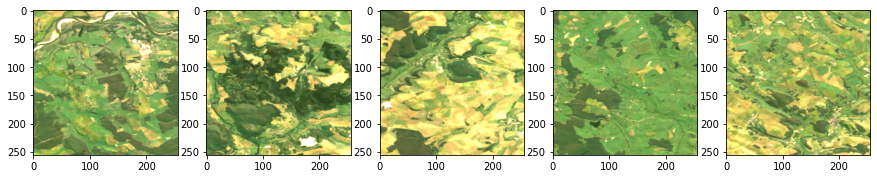

In [17]:
fig = plt.figure(figsize=(15,7))

for i in range(5):
  plt.subplot(1, 5, i+1 )
  plt.imshow(np.flip(images[i, :, : , 1:4].numpy(), axis=2)*10)

In [50]:
print(labels.shape)
labels_dim = np.resize(labels, (16,256,256,3))
print(labels_dim.shape)

(16, 256, 256, 1)
(16, 256, 256, 3)


In [52]:
labels_dim

array([[[[2., 2., 2.],
         [2., 2., 2.],
         [2., 2., 2.],
         ...,
         [2., 2., 2.],
         [2., 2., 2.],
         [2., 2., 2.]],

        [[2., 2., 2.],
         [2., 2., 2.],
         [2., 2., 2.],
         ...,
         [2., 2., 2.],
         [2., 2., 2.],
         [2., 2., 2.]],

        [[2., 2., 2.],
         [2., 2., 2.],
         [2., 2., 2.],
         ...,
         [2., 2., 2.],
         [2., 2., 2.],
         [2., 2., 2.]],

        ...,

        [[2., 2., 2.],
         [2., 2., 2.],
         [2., 2., 2.],
         ...,
         [2., 2., 2.],
         [2., 2., 2.],
         [2., 2., 2.]],

        [[2., 2., 2.],
         [2., 2., 2.],
         [2., 2., 2.],
         ...,
         [2., 2., 2.],
         [2., 2., 2.],
         [2., 2., 2.]],

        [[2., 2., 2.],
         [2., 2., 2.],
         [2., 2., 2.],
         ...,
         [2., 2., 2.],
         [2., 2., 2.],
         [2., 2., 2.]]],


       [[[2., 2., 2.],
         [2., 2., 2.],
         [2., 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


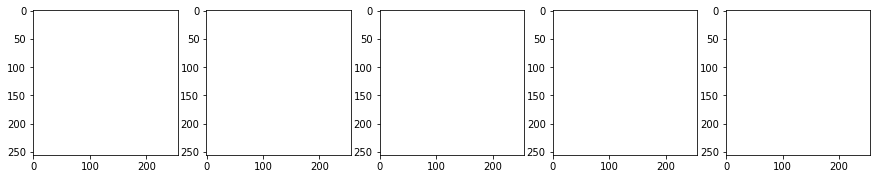

In [53]:
# unexpected error when trying to print the target images
fig = plt.figure(figsize=(15,7))

for i in range(5):
  plt.subplot(1,5,i+1)
  plt.imshow(labels_dim[i,:,:,:])

In [54]:
def get_eval_dataset():
    """Get the preprocessed evaluation dataset
    Returns: 
    A tf.data.Dataset of evaluation data.
    """
    glob = 'gs://' + BUCKET + '/' + FOLDER + '/' + EVAL_BASE + '*'
    dataset = get_dataset(glob)
    dataset = dataset.batch(1).repeat()
    return dataset

evaluation = get_eval_dataset()

In [55]:
evaluation, training

(<RepeatDataset shapes: ((None, 256, 256, 9), (None, 256, 256, 1)), types: (tf.float32, tf.float32)>,
 <RepeatDataset shapes: ((None, 256, 256, 9), (None, 256, 256, 1)), types: (tf.float32, tf.float32)>)

In [56]:
# Load a trained model. 50 epochs. 25 hours. Final RMSE ~0.08.
MODEL_DIR = 'gs://ee-docs-demos/fcnn-demo/trainer/model'
model_pretrained = tf.keras.models.load_model(MODEL_DIR)
model_pretrained.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, None, None, 3 2624        input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, None, None, 3 128         conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, None, None, 3 0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [57]:
from tensorflow.keras.metrics import MeanIoU
iou = Mean

In [58]:
model_pretrained.compile(
		optimizer=optimizers.get(OPTIMIZER), 
		loss=losses.get(LOSS),
		metrics=["mse"])

In [ ]:
es = EarlyStopping(monitor='val_loss', mode='auto', patience=5, verbose=1, restore_best_weights=True)

history = model_pretrained.fit(
   x=training, 
    epochs=10, 
    steps_per_epoch=int(TRAIN_SIZE / BATCH_SIZE), 
    validation_data=evaluation,
    validation_steps=EVAL_SIZE,
    callbacks=[es]  
)

Epoch 1/10
1000/1000 [==============================] - 1162s 1s/step - loss: 0.6890 - mse: 0.6890 - val_loss: 0.7724 - val_mse: 0.7724
Epoch 2/10
 547/1000 [===============>..............] - ETA: 6:24 - loss: 0.6732 - mse: 0.6732

In [3]:
def plot_history(history, title='', axs=None, exp_name=""):
    if axs is not None:
        ax1, ax2 = axs
    else:
        f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
    
    if len(exp_name) > 0 and exp_name[0] != '_':
        exp_name = '_' + exp_name
    ax1.plot(history.history['loss'], label='train' + exp_name)
    ax1.plot(history.history['val_loss'], label='val' + exp_name)
    #ax1.set_ylim(0., 2.2)
    ax1.set_title('loss')
    ax1.legend()

    ax2.plot(history.history['mse'], label='train mse'  + exp_name)
    ax2.plot(history.history['val_mse'], label='val mse'  + exp_name)
    #ax2.set_ylim(0.25, 1.)
    ax2.set_title('Accuracy')
    ax2.legend()
    return (ax1, ax2)

In [ ]:
plot_history(history)

In [25]:
MODEL_SAVE = 'gs://' + BUCKET + '/' + 'model_trained'
model_pretrained.save(MODEL_SAVE)

INFO:tensorflow:Assets written to: gs://forest_guard_bucket/model_trained/assets


## Prediction

In [1]:
def doExport(out_image_base, kernel_buffer, region):
  """Run the image export task.  Block until complete.
  """
  task = ee.batch.Export.image.toCloudStorage(
    image = image.select(BANDS),
    description = out_image_base,
    bucket = BUCKET,
    fileNamePrefix = FOLDER + '/' + out_image_base,
    region = region.getInfo()['coordinates'],
    scale = 30,
    fileFormat = 'TFRecord',
    maxPixels = 1e10,
    formatOptions = {
      'patchDimensions': KERNEL_SHAPE,
      'kernelSize': kernel_buffer,
      'compressed': True,
      'maxFileSize': 104857600
    }
  )
  task.start()

  # Block until the task completes.
  print('Running image export to Cloud Storage...')
  import time
  while task.active():
    time.sleep(30)

  # Error condition
  if task.status()['state'] != 'COMPLETED':
    print('Error with image export.')
  else:
    print('Image export completed.')

In [2]:
def doPrediction(out_image_base, user_folder, kernel_buffer, region):
  """Perform inference on exported imagery, upload to Earth Engine.
  """

  print('Looking for TFRecord files...')

  # Get a list of all the files in the output bucket.
  filesList = !gsutil ls 'gs://'{BUCKET}'/'{FOLDER}

  # Get only the files generated by the image export.
  exportFilesList = [s for s in filesList if out_image_base in s]

  # Get the list of image files and the JSON mixer file.
  imageFilesList = []
  jsonFile = None
  for f in exportFilesList:
    if f.endswith('.tfrecord.gz'):
      imageFilesList.append(f)
    elif f.endswith('.json'):
      jsonFile = f

  # Make sure the files are in the right order.
  imageFilesList.sort()

  from pprint import pprint
  pprint(imageFilesList)
  print(jsonFile)

  import json
  # Load the contents of the mixer file to a JSON object.
  jsonText = !gsutil cat {jsonFile}
  # Get a single string w/ newlines from the IPython.utils.text.SList
  mixer = json.loads(jsonText.nlstr)
  pprint(mixer)
  patches = mixer['totalPatches']

  # Get set up for prediction.
  x_buffer = int(kernel_buffer[0] / 2)
  y_buffer = int(kernel_buffer[1] / 2)

  buffered_shape = [
      KERNEL_SHAPE[0] + kernel_buffer[0],
      KERNEL_SHAPE[1] + kernel_buffer[1]]

  imageColumns = [
    tf.io.FixedLenFeature(shape=buffered_shape, dtype=tf.float32) 
      for k in BANDS
  ]

  imageFeaturesDict = dict(zip(BANDS, imageColumns))

  def parse_image(example_proto):
    return tf.io.parse_single_example(example_proto, imageFeaturesDict)

  def toTupleImage(inputs):
    inputsList = [inputs.get(key) for key in BANDS]
    stacked = tf.stack(inputsList, axis=0)
    stacked = tf.transpose(stacked, [1, 2, 0])
    return stacked

   # Create a dataset from the TFRecord file(s) in Cloud Storage.
  imageDataset = tf.data.TFRecordDataset(imageFilesList, compression_type='GZIP')
  imageDataset = imageDataset.map(parse_image, num_parallel_calls=5)
  imageDataset = imageDataset.map(toTupleImage).batch(1)

  # Perform inference.
  print('Running predictions...')
  predictions = m.predict(imageDataset, steps=patches, verbose=1)
  # print(predictions[0])

  print('Writing predictions...')
  out_image_file = 'gs://' + BUCKET + '/' + FOLDER + '/' + out_image_base + '.TFRecord'
  writer = tf.io.TFRecordWriter(out_image_file)
  patches = 0
  for predictionPatch in predictions:
    print('Writing patch ' + str(patches) + '...')
    predictionPatch = predictionPatch[
        x_buffer:x_buffer+KERNEL_SIZE, y_buffer:y_buffer+KERNEL_SIZE]

    # Create an example.
    example = tf.train.Example(
      features=tf.train.Features(
        feature={
          'impervious': tf.train.Feature(
              float_list=tf.train.FloatList(
                  value=predictionPatch.flatten()))
        }
      )
    )
    # Write the example.
    writer.write(example.SerializeToString())
    patches += 1

  writer.close()

  # Start the upload.
  out_image_asset = user_folder + '/' + out_image_base
  !earthengine upload image --asset_id={out_image_asset} {out_image_file} {jsonFile}